# FINENG Project 6B
 
Donato Augenti - 10793800 
\
Dario Delmonaco - 10679120
\
Ulysse Grimault - 11056380 
\
Davide Rota - 10796557

## Librairies

In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from Functions import *
from Calibration_SABR import *
from Calibration_Bachelier import *
from Certificate_pricing import *
from bootstrap import bootstrap
import seaborn as sns
import warnings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

/Users/ulyssegrimault/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data

In [2]:
curve_data = scipy.io.loadmat('curve.mat')
fra_data = scipy.io.loadmat('FRA.mat')
grid_B_data = scipy.io.loadmat('grid-B.mat')
ten_exp_data = scipy.io.loadmat('TenExp.mat')
atm_sigma_data = scipy.io.loadmat('atm_sigma.mat')
K_data = scipy.io.loadmat('K.mat')


In [3]:
RT = curve_data['RT'].flatten()
Dates = curve_data['Dates'].flatten()
Fixing = fra_data['Fixing'].flatten()
Settle = fra_data['Settle'].flatten()
Expiry = fra_data['Expiry'].flatten()
K= K_data['K'].flatten()
grid_B = grid_B_data['gridB'].flatten()
T= ten_exp_data['T'].flatten()
Exp= ten_exp_data['Exp'].flatten()
atm_sigma = atm_sigma_data['atm_sigma'].flatten()
KeysFRA = fra_data['Keys_fra'].flatten()
Type= curve_data['Type'].flatten()
Type = [t[0] for t in Type]




Fixing = np.array([Functions.converter(dt) for dt in Fixing])
Settle = np.array([Functions.converter(dt) for dt in Settle])
Expiry = np.array([Functions.converter(dt) for dt in Expiry])
Dates = np.array([Functions.converter(dt) for dt in Dates])
today =datetime.datetime(2021, 4, 30)

## Boostrap

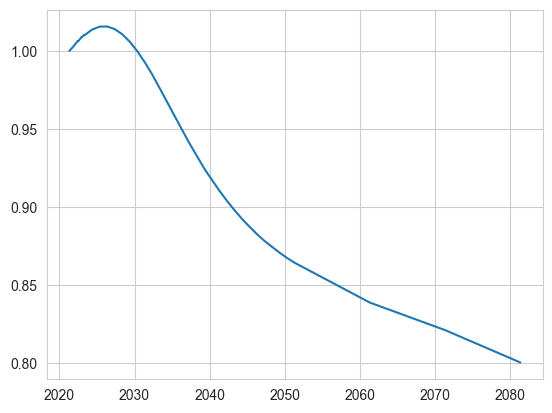

In [4]:
dates,discounts=bootstrap.bootstrap(today, RT, Dates, Fixing, Settle, Expiry, Type)
plt.plot(dates, discounts)
plt.show()

## Forward  Swap Rate

In [5]:
N = len(T)
fwd_swp_rate = np.zeros(N)
today= dates[0]
for i in range(N):
    tenor_months = T[i]
    expiry_months = Exp[i]

   
    start_date = today + relativedelta(months=+expiry_months)
    fwd_swp_rate[i] = Functions.get_fwd_swap_rate(today, dates, discounts, start_date, tenor_months // 12, q=2)

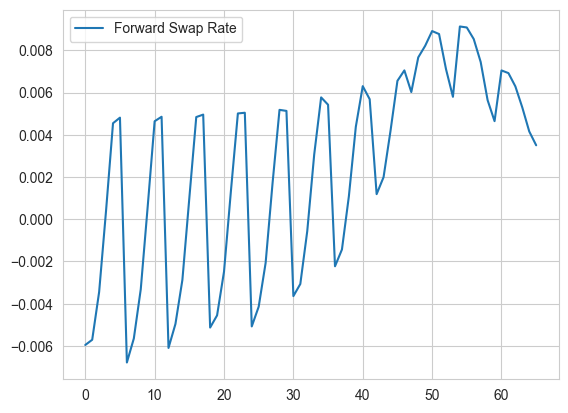

In [6]:
plt.plot(fwd_swp_rate, label='Forward Swap Rate')
plt.legend()
plt.show()

## Calibration of SABR model

### Basic Calibration

First we perform a "base" calibration

In [7]:
flag="Basic"
[alpha_vec,rho_vec,nu_vec,sigma_model,sigma_market,obj_value]=Calibration_SABR.sabr_calibration(dates,discounts,T,Exp,atm_sigma,grid_B.reshape(-1, 12),today,K,flag)

100%|██████████| 66/66 [00:36<00:00,  1.80it/s]


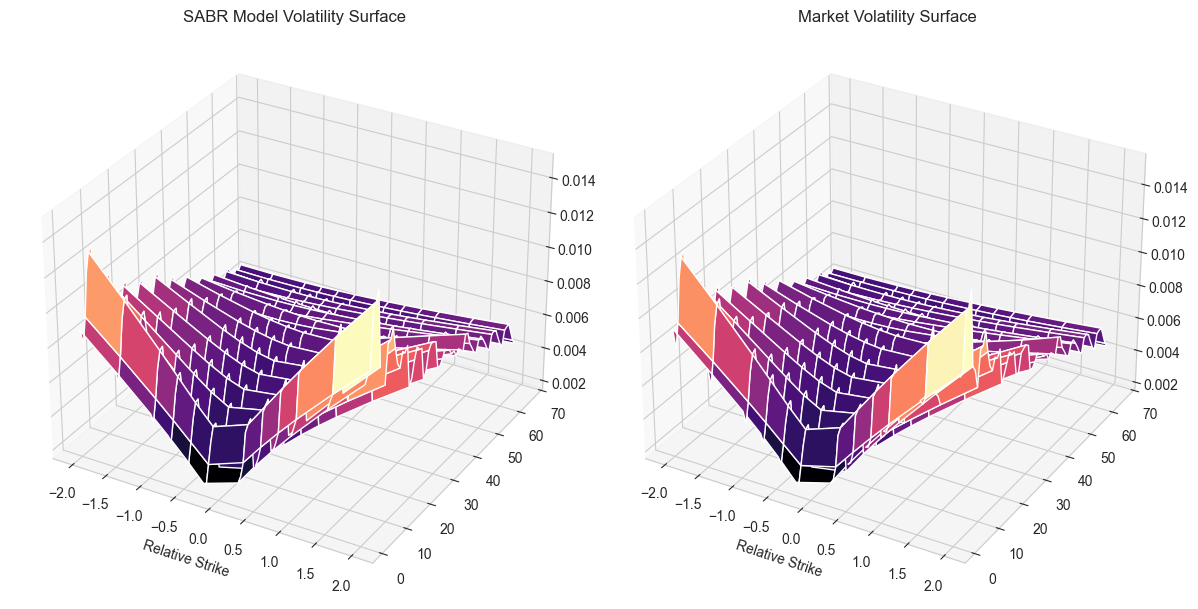

In [8]:
sigma_model_reshaped = sigma_model.reshape(66, 12)
sigma_market_reshaped = sigma_market.reshape(66, 12)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(K, np.arange(1, 67))
ax.plot_surface(X, Y, sigma_model_reshaped, cmap='magma')


ax.set_xlabel('Relative Strike')
ax.set_title('SABR Model Volatility Surface')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, sigma_market_reshaped, cmap='magma')


ax2.set_xlabel('Relative Strike')
ax2.set_title('Market Volatility Surface')

plt.tight_layout()
plt.show()

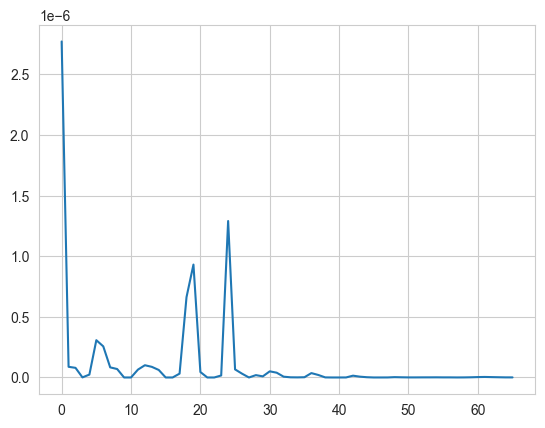

In [9]:
plt.plot(obj_value, label='Objective Value')

### Cascade Calibration

In [10]:
flag="Cascade"
[alpha_cascade,rho_cascade,nu_cascade,sigma_model_cascade,sigma_market,obj_value_cascade]=Calibration_SABR.sabr_calibration(dates,discounts,T,Exp,atm_sigma,grid_B.reshape(-1, 12),today,K,flag)

100%|██████████| 66/66 [00:01<00:00, 62.41it/s]


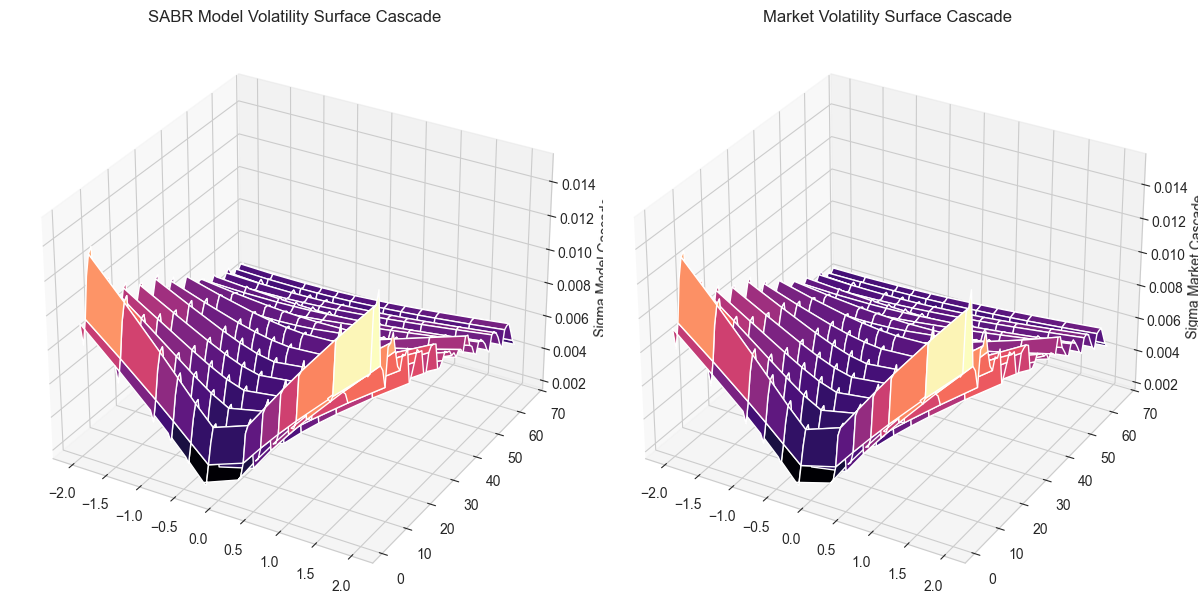

In [11]:

sigma_model_cascade_reshaped = sigma_model_cascade.reshape(66, 12)
sigma_market_reshaped = sigma_market.reshape(66, 12)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(K, np.arange(1, 67))
ax.plot_surface(X, Y, sigma_model_cascade_reshaped, cmap='magma')
ax.set_zlabel('Sigma Model Cascade')
ax.set_title('SABR Model Volatility Surface Cascade')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, sigma_market_reshaped, cmap='magma')
ax2.set_zlabel('Sigma Market Cascade')
ax2.set_title('Market Volatility Surface Cascade')
plt.tight_layout()
plt.show()


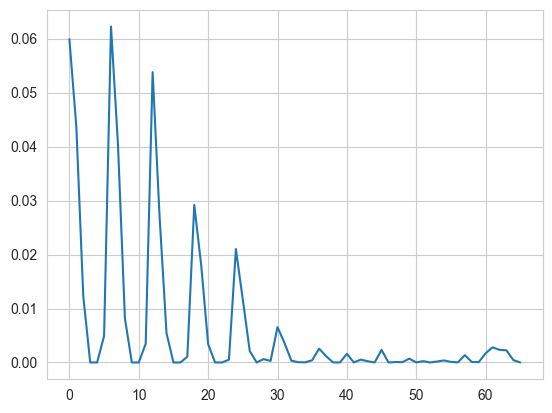

In [12]:
plt.plot(obj_value_cascade, label='Objective Value Cascade')

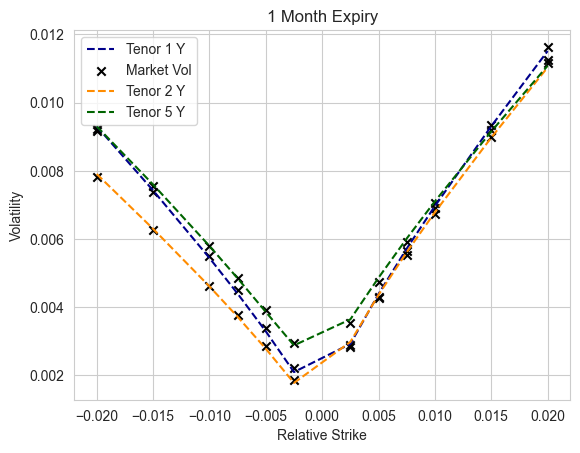

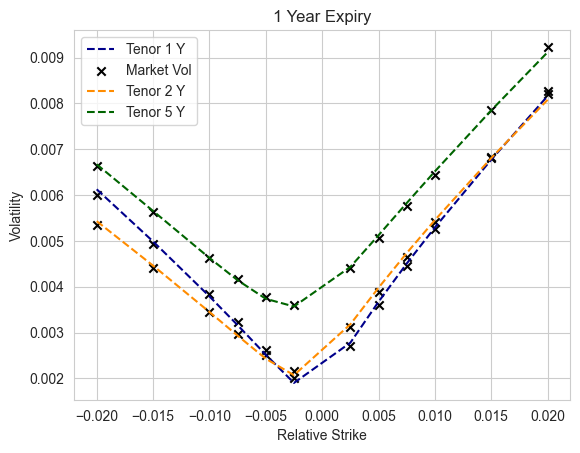

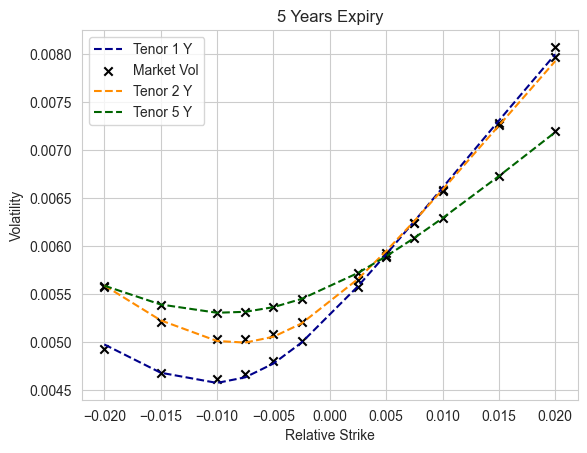

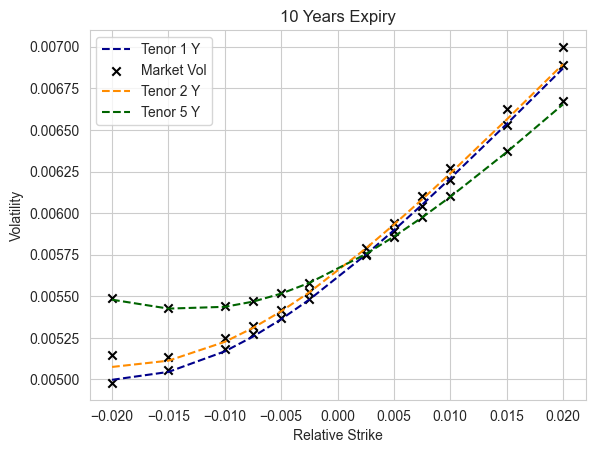

In [13]:
# plot the 6 first rows of I and sigma_market ( with dark cross to compare)
sns.set_style("whitegrid")
color=['darkblue', 'darkorange', 'darkgreen']
for i in range(3):
    plt.plot(K/100, sigma_model_cascade[i], label=f"Tenor {int(T[i]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[i],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[i], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('1 Month Expiry')
plt.show()

color=['darkblue', 'darkorange', 'darkgreen']
for i,n in enumerate(range(24,27)):
    plt.plot(K/100, sigma_model_cascade[n], label=f"Tenor {int(T[n]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[n],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[n], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('1 Year Expiry')
plt.show()

for i,n in enumerate(range(42,45)):
    plt.plot(K/100, sigma_model_cascade[n], label=f"Tenor {int(T[n]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[n],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[n], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('5 Years Expiry')
plt.show()
for i,n in enumerate(range(48,51)):
    plt.plot(K/100,sigma_model_cascade[n], label=f"Tenor {int(T[n]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[n],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[n], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('10 Years Expiry')
plt.show()

Let's compare the parameters obtained in the two calibration methods :

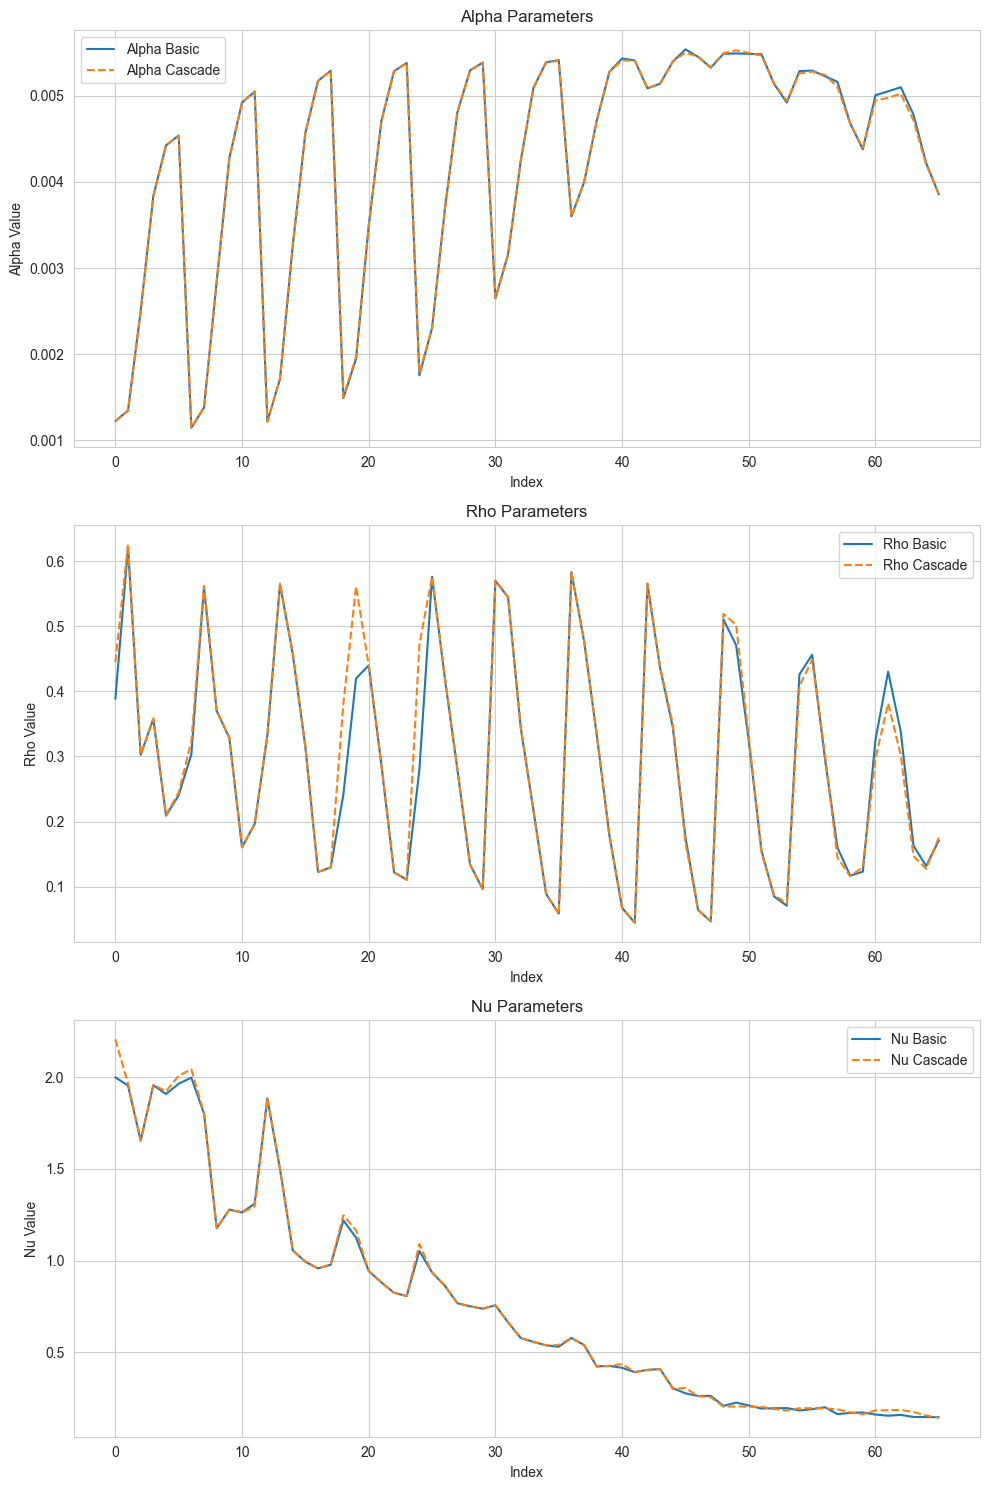

In [14]:

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(alpha_vec, label='Alpha Basic')
axs[0].plot(alpha_cascade, label='Alpha Cascade', linestyle='--')
axs[0].set_title('Alpha Parameters')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Alpha Value')
axs[0].legend()
axs[1].plot(rho_vec, label='Rho Basic')
axs[1].plot(rho_cascade, label='Rho Cascade', linestyle='--')
axs[1].set_title('Rho Parameters')
axs[1].set_xlabel('Index')  
axs[1].set_ylabel('Rho Value')
axs[1].legend()
axs[2].plot(nu_vec, label='Nu Basic')
axs[2].plot(nu_cascade, label='Nu Cascade', linestyle='--')
axs[2].set_title('Nu Parameters')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Nu Value')
axs[2].legend()
plt.tight_layout()
plt.show()

## Calibration Additive bachelier Model

In [15]:
flag1= "Cascade"
flag2= "FFT"
[sigma_vec, k_vec, eta_vec, I]=Calibration_Bachelier.additive_bachelier_calibration(dates, discounts, T, Exp, atm_sigma, grid_B.reshape(-1, 12), today, K, flag1, flag2)

100%|██████████| 66/66 [03:28<00:00,  3.16s/it]


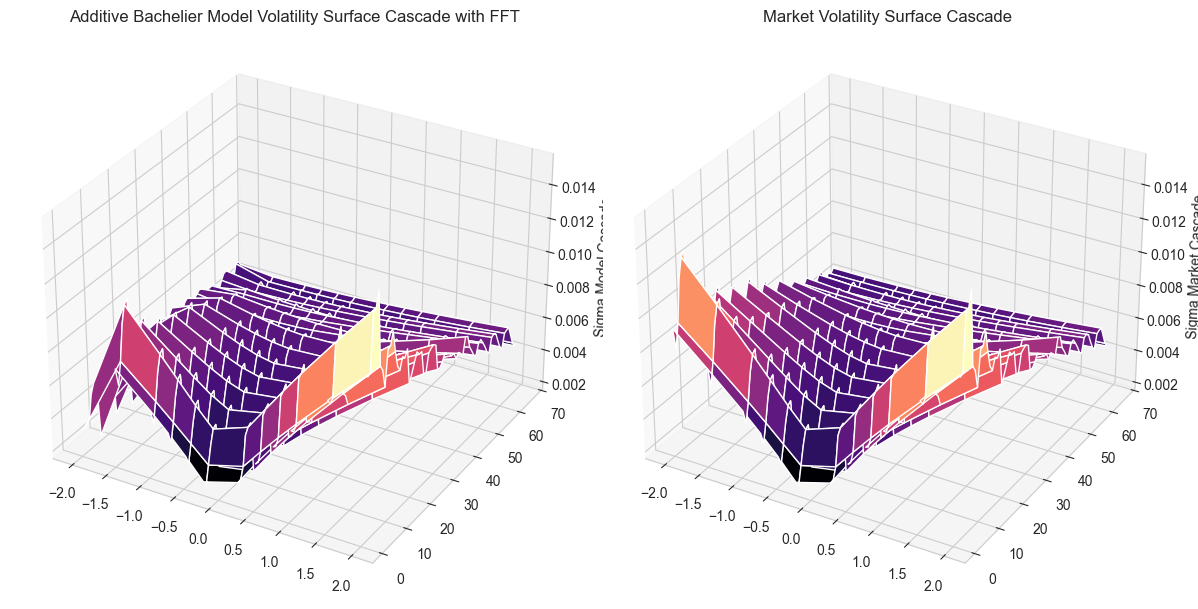

In [16]:

sigma_model_cascade_reshaped = I.reshape(66, 12)
sigma_market_reshaped = sigma_market.reshape(66, 12)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(K, np.arange(1, 67))
ax.plot_surface(X, Y, sigma_model_cascade_reshaped, cmap='magma')
ax.set_zlabel('Sigma Model Cascade')
ax.set_title('Additive Bachelier Model Volatility Surface Cascade with FFT')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, sigma_market_reshaped, cmap='magma')
ax2.set_zlabel('Sigma Market Cascade')
ax2.set_title('Market Volatility Surface Cascade')
plt.tight_layout()
plt.show()


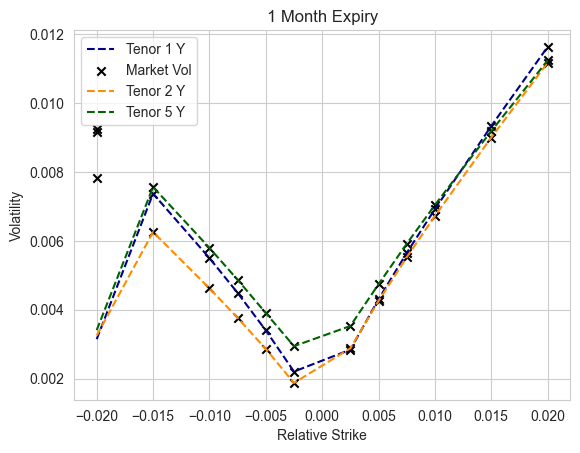

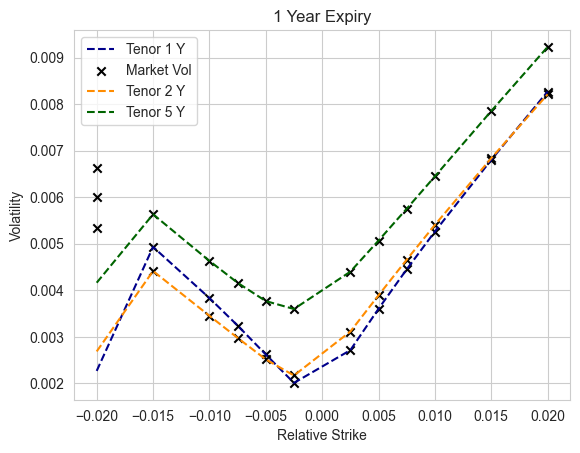

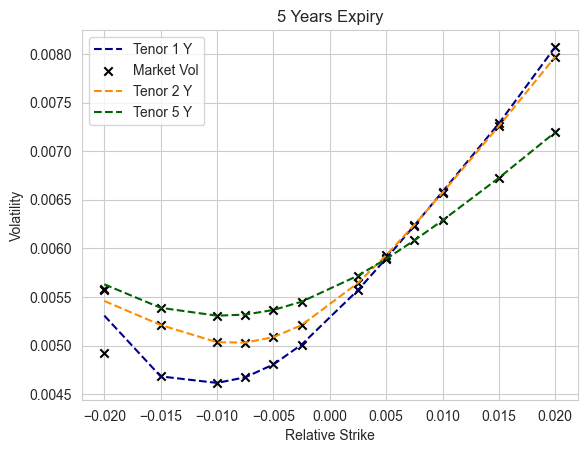

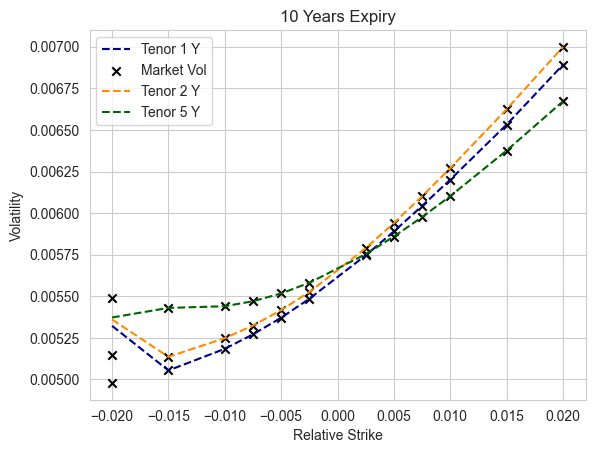

In [17]:
# plot the 6 first rows of I and sigma_market ( with dark cross to compare)
sns.set_style("whitegrid")
color=['darkblue', 'darkorange', 'darkgreen']
for i in range(3):
    plt.plot(K/100, I[i], label=f"Tenor {int(T[i]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[i],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[i], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('1 Month Expiry')
plt.show()

color=['darkblue', 'darkorange', 'darkgreen']
for i,n in enumerate(range(24,27)):
    plt.plot(K/100, I[n], label=f"Tenor {int(T[n]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[n],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[n], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('1 Year Expiry')
plt.show()

for i,n in enumerate(range(42,45)):
    plt.plot(K/100, I[n], label=f"Tenor {int(T[n]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[n],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[n], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('5 Years Expiry')
plt.show()
for i,n in enumerate(range(48,51)):
    plt.plot(K/100, I[n], label=f"Tenor {int(T[n]/12)} Y", color=color[i], linestyle='--')
    if i <1:
         plt.scatter(K/100, sigma_market[n],label='Market Vol',color='black', marker='x')
    else :
         plt.scatter(K/100, sigma_market[n], color='black', marker='x')
plt.legend()
plt.xlabel('Relative Strike')
plt.ylabel('Volatility')
plt.title('10 Years Expiry')
plt.show()

## Certificate Pricing

In [18]:

sett_date = datetime.datetime.strptime("05-May-2021", "%d-%b-%Y")
q = 2

coupon_payment_dates, reset_dates = Certificate_pricing.schedule_following_BD_convention(sett_date, q)
expiry_dates = [today + relativedelta(months=int(m)) for m in Exp[::6]]
NN = np.arange(4, 1001) 
tenors = np.array([2, 2, 5, 5, 10, 10])

NPV_sup, NPV_sub = Certificate_pricing.compute_NPV_coupons(sett_date, dates,discounts,coupon_payment_dates,reset_dates,expiry_dates,tenors,q,I,K,NN)


Computing NPV for coupon date: 2021-11-05 00:00:00
reset date: 2021-11-03 00:00:00
tenor: 2
Computing NPV for coupon date: 2022-05-05 00:00:00
reset date: 2022-05-03 00:00:00
tenor: 2
Computing NPV for coupon date: 2022-11-07 00:00:00
reset date: 2022-11-03 00:00:00
tenor: 5
Computing NPV for coupon date: 2023-05-05 00:00:00
reset date: 2023-05-03 00:00:00
tenor: 5
Computing NPV for coupon date: 2023-11-06 00:00:00
reset date: 2023-11-02 00:00:00
tenor: 10
Computing NPV for coupon date: 2024-05-06 00:00:00
reset date: 2024-05-02 00:00:00
tenor: 10


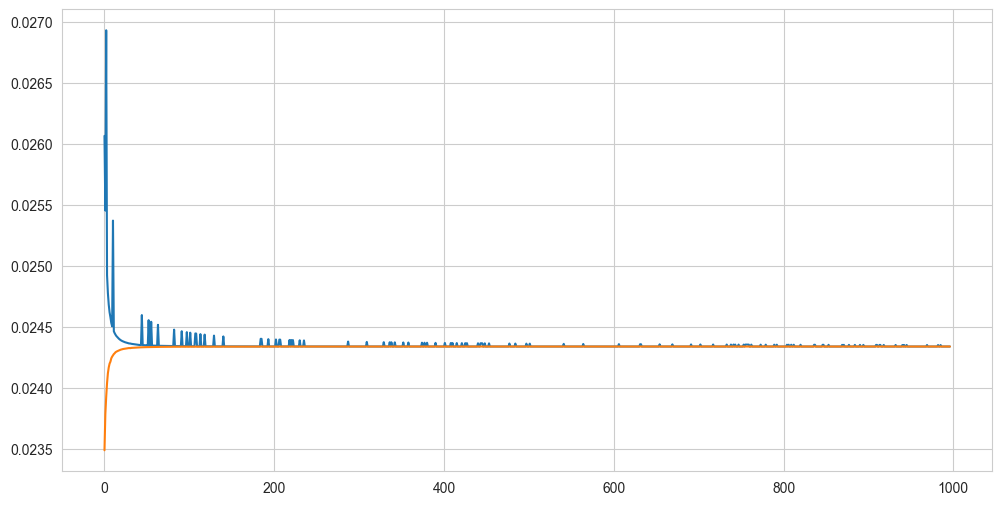

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(NPV_sup, label='NPV Sup')
plt.plot(NPV_sub, label='NPV Sub')

In [20]:

prot_sup = 100 * Certificate_pricing.compute_protection(NPV_sup, today, sett_date, coupon_payment_dates, dates, discounts)
prot_sub = 100 * Certificate_pricing.compute_protection(NPV_sub, today, sett_date, coupon_payment_dates, dates, discounts)


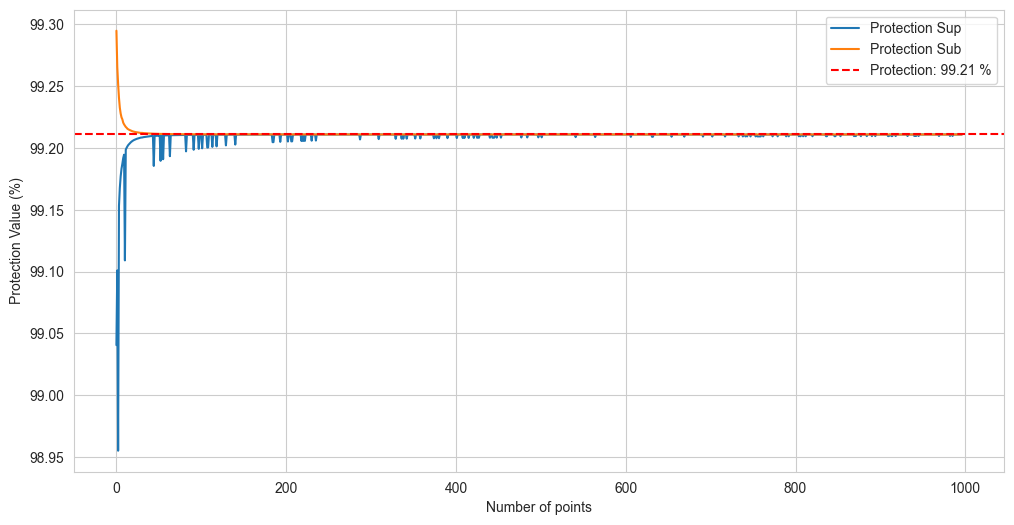

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(prot_sup, label='Protection Sup', linestyle='-')
plt.plot(prot_sub, label='Protection Sub', linestyle='-')

plt.axhline(y=prot_sup[-1], color='red', linestyle='--', label=f'Protection: {prot_sup[-1]:.2f} %')

plt.xlabel('Number of points')
plt.ylabel('Protection Value (%)')
plt.legend()

In [22]:
N = np.where(np.abs(prot_sup - prot_sub) < 1e-4)[0][0]
print(f"Protection: {prot_sup[N]:.2f} %")
print(f"Number of points: {N}")

Protection: 99.21 %
Number of points: 199
